### 1.Import das Bibliotecas

In [717]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.creation import MathFeatures
import xgboost as xgb
from joblib import dump
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [693]:
base_path = r"C:\Users\bruno\OneDrive\Desktop\Modelos\Classification"
file_path = f"{base_path}\\dataset\\heart_failure_clinical_records_dataset.csv"

In [694]:
df = pd.read_csv(file_path)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


#### 2. Dicionário de Dados

- **`age`**: Idade do paciente em anos.
- **`anaemia`**: Indica se o paciente tem anemia (0 = Não, 1 = Sim).
- **`creatinine_phosphokinase`**: Nível de creatinina fosfoquinase no sangue (mcg/L).
- **`diabetes`**: Indica se o paciente tem diabetes (0 = Não, 1 = Sim).
- **`ejection_fraction`**: Porcentagem de sangue saindo do coração a cada contração (%).
- **`high_blood_pressure`**: Indica se o paciente tem hipertensão (0 = Não, 1 = Sim).
- **`platelets`**: Contagem de plaquetas no sangue (quilhões/L).
- **`serum_creatinine`**: Nível de creatinina sérica no sangue (mg/dL).
- **`serum_sodium`**: Nível de sódio sérico no sangue (mEq/L).
- **`sex`**: Sexo do paciente (0 = Feminino, 1 = Masculino).
- **`smoking`**: Indica se o paciente é fumante (0 = Não, 1 = Sim).
- **`time`**: Tempo de acompanhamento em dias.
- **`DEATH_EVENT`**: Variável Alvo - Indica se houve óbito durante o acompanhamento (0 = Não, 1 = Sim).

In [695]:
df.shape

(299, 13)

In [696]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### 2. Data Splitting

In [697]:
X = df.drop(columns=['DEATH_EVENT'])  # Variáveis independentes
y = df['DEATH_EVENT']  # Variável dependente

# Divisão dos dados: 75% treino, 25% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Exibe as dimensões dos dados divididos
print("Treinamento:", X_train.shape, y_train.shape)
print("Teste:", X_test.shape, y_test.shape)

Treinamento: (224, 12) (224,)
Teste: (75, 12) (75,)


In [698]:
# Combine os dados de treino
train_data = pd.concat([X_train, y_train], axis=1)

# Visualize os primeiros registros
print(train_data.head())

      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
225  75.0        0                       675         1                 60   
78   75.0        1                       203         1                 38   
66   42.0        1                       250         1                 15   
296  45.0        0                      2060         1                 60   
192  50.0        1                       121         1                 40   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
225                    0   265000.0               1.4           125    0   
78                     1   283000.0               0.6           131    1   
66                     0   213000.0               1.3           136    0   
296                    0   742000.0               0.8           138    0   
192                    0   260000.0               0.7           130    1   

     smoking  time  DEATH_EVENT  
225        0   205            0  
78         1

##### 2.1 Correlação de Pearson

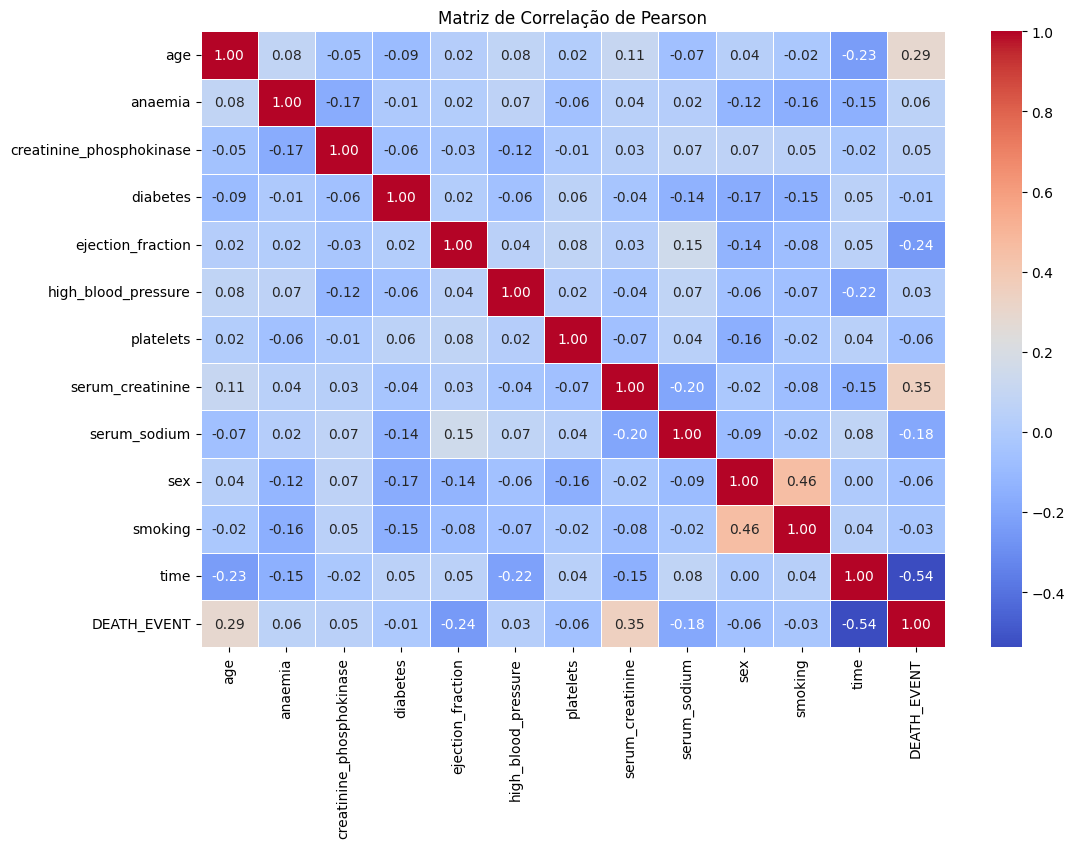

In [699]:
# Calcular a correlação de Spearman
cp = train_data.corr(method='pearson')

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(cp, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação de Pearson')
plt.show()

#### 2.2 Análise das Distribuições das variáveis numéricas

In [700]:
# Resumo estatístico das variáveis
distribution = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
flags = ['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']

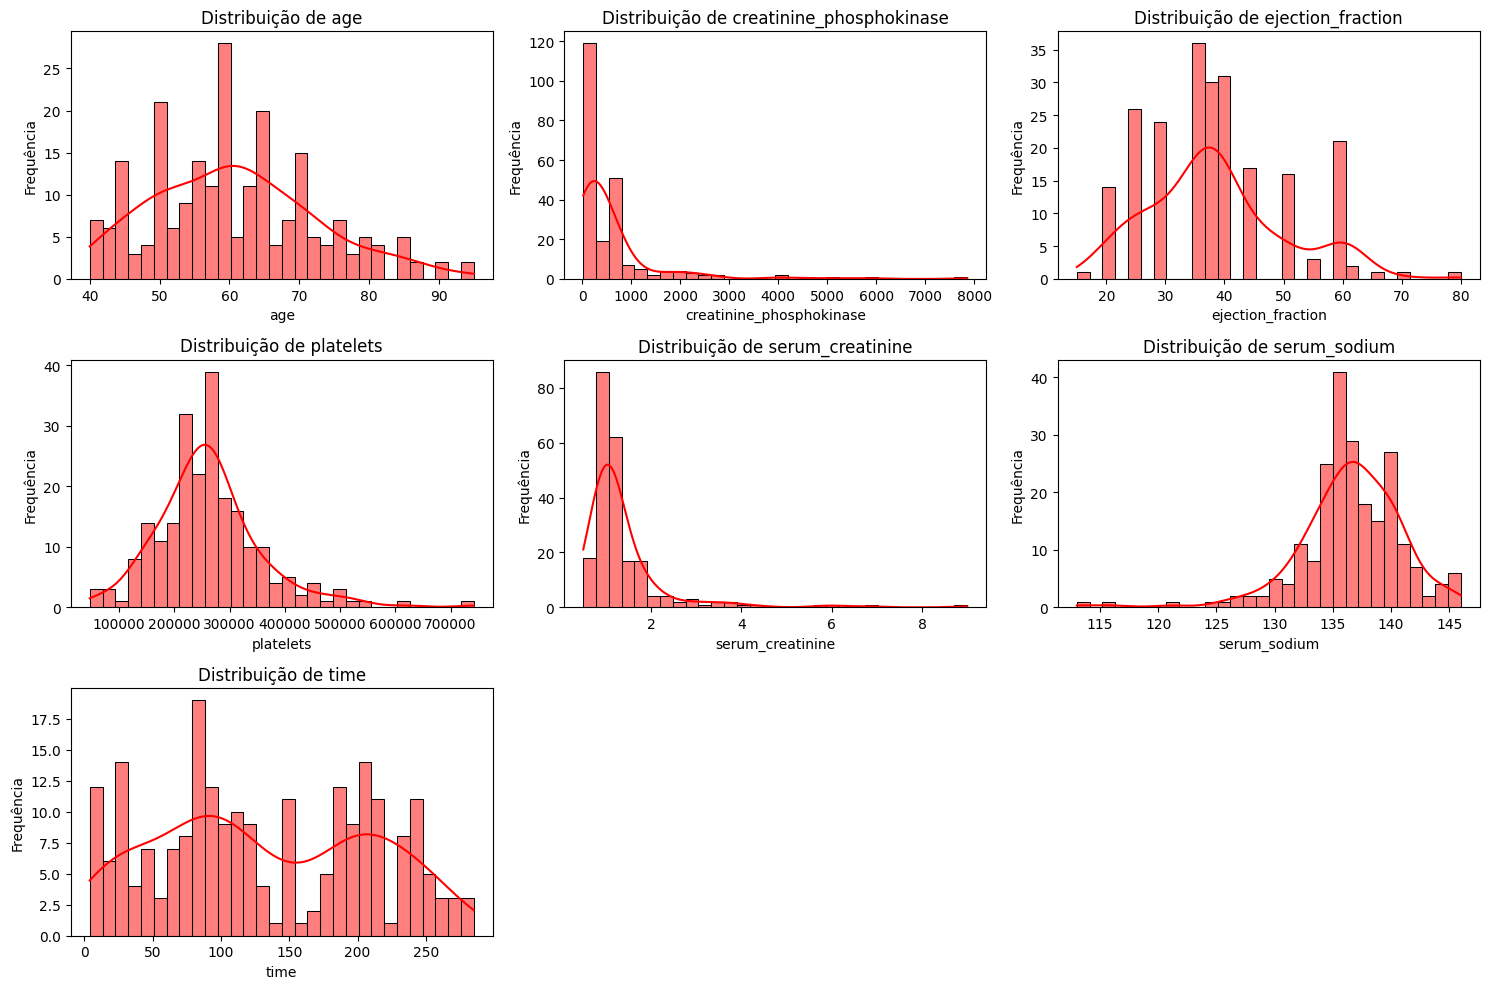

In [701]:
# Definir o tamanho da figura
plt.figure(figsize=(15, 10))

# Criar um subplot para cada variável
for i, var in enumerate(distribution, 1):
    plt.subplot(3, 3, i)  # Organizar os gráficos em 3x3 (ajustar conforme necessário)
    sns.histplot(X_train[var], kde=True, bins=30, color='red', edgecolor='black')  # Histograma com KDE
    plt.title(f'Distribuição de {var}')
    plt.xlabel(var)
    plt.ylabel('Frequência')

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()


###### A única variável que não é contínua nesse conjunto é ejection_fraction, e ele será utilizada de maneira diferente nos processos

##### 2.3 Boxplot

In [638]:
var_simetria = ['age','creatinine_phosphokinase','platelets','serum_creatinine','serum_sodium','time']
var_bin = ['ejection_fraction']

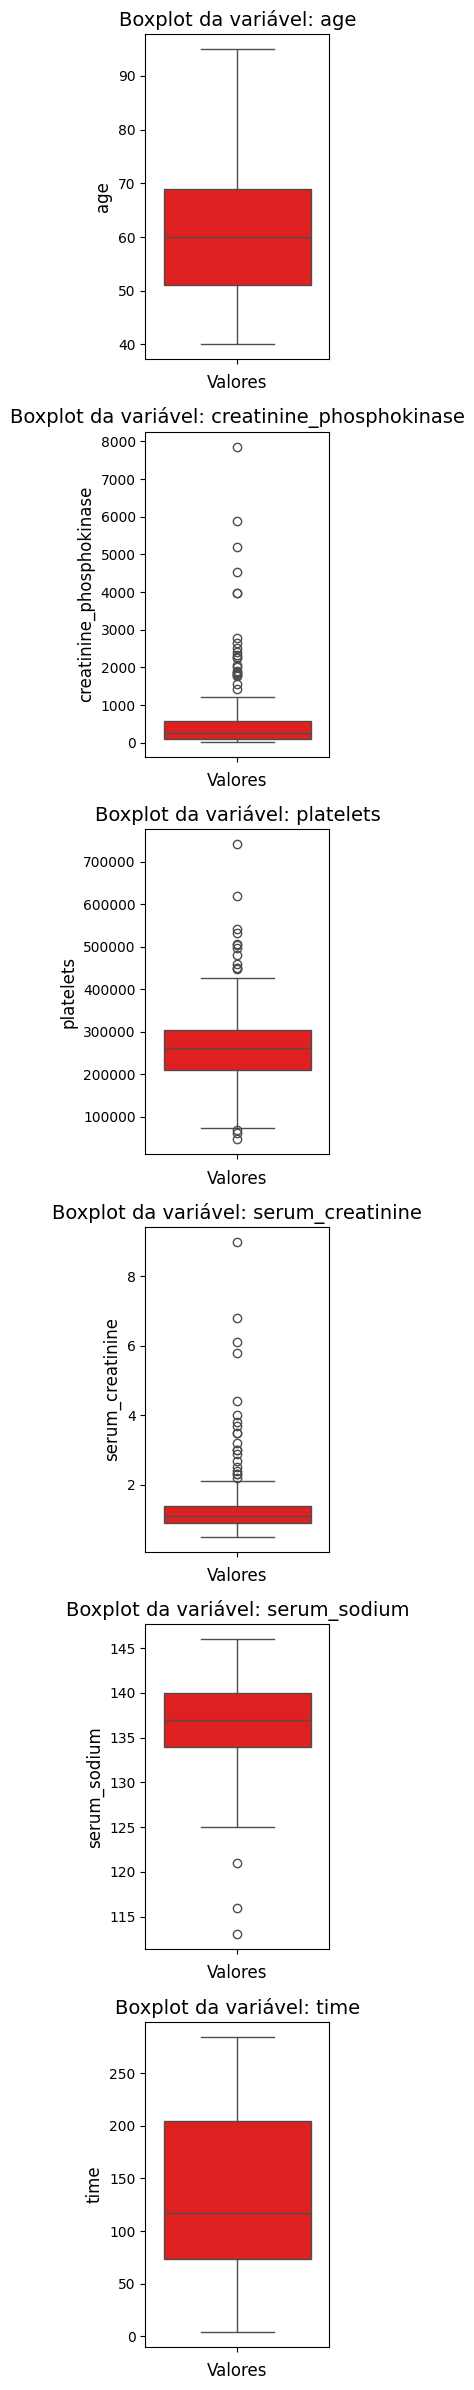

In [702]:
# Configuração dos subplots
fig, axes = plt.subplots(nrows=len(var_simetria), ncols=1, figsize=(3, 4 * len(var_simetria)))

# Loop para criar um boxplot para cada variável no eixo Y
for i, var in enumerate(var_simetria):
    sns.boxplot(data=X_train, y=var, ax=axes[i], color="red")
    axes[i].set_title(f"Boxplot da variável: {var}", fontsize=14)
    axes[i].set_ylabel(var, fontsize=12)
    axes[i].set_xlabel("Valores", fontsize=12)

# Ajuste para evitar sobreposição
plt.tight_layout()
plt.show()


#### 2.3 Assimetria e Curtose

In [703]:
# Calculando assimetria (skewness) e curtose (kurtosis)
asimetria_curtose = pd.DataFrame({
    'Variável': var_simetria,
    'Assimetria': X_train[var_simetria].skew(),
    'Curtose': X_train[var_simetria].kurtosis()
}).reset_index(drop=True)

# Exibindo o resultado
print(asimetria_curtose)


                   Variável  Assimetria    Curtose
0                       age    0.444188  -0.129606
1  creatinine_phosphokinase    4.079929  21.138937
2                 platelets    1.115137   3.390189
3          serum_creatinine    4.246155  23.275706
4              serum_sodium   -1.329233   5.088287
5                      time    0.111214  -1.202437


###### Para reduzir principalmente a curtose de algumas variáveis (presença de muitos valore Outliers), vou utilizar a transformação logarítmica para diminuir significativamente os valores extremos

##### 2.4 **`serum_creatinine`**,  **`serum_sodium`** e **`creatinine_phosphokinase`**

In [704]:
# Box-Cox
# Aplicando Box-Cox no X_train e obtendo o lambda
X_train['serum_creatinine'], lambda_creatinine = stats.boxcox(X_train['serum_creatinine'])
X_train['serum_sodium'], lambda_sodium = stats.boxcox(X_train['serum_sodium'])
X_train['creatinine_phosphokinase'], lambda_creatinine_phosphokinase = stats.boxcox(X_train['creatinine_phosphokinase'])
X_train['platelets'], lambda_platelets = stats.boxcox(X_train['platelets'])

# Aplicando Box-Cox no X_test com o mesmo lambda
X_test['serum_creatinine'] = stats.boxcox(X_test['serum_creatinine'], lmbda=lambda_creatinine)
X_test['serum_sodium'] = stats.boxcox(X_test['serum_sodium'],lmbda=lambda_sodium)
X_test['creatinine_phosphokinase'] = stats.boxcox(X_test['creatinine_phosphokinase'],lmbda=lambda_creatinine_phosphokinase)
X_test['platelets'] = stats.boxcox(X_test['platelets'],lmbda=lambda_platelets)


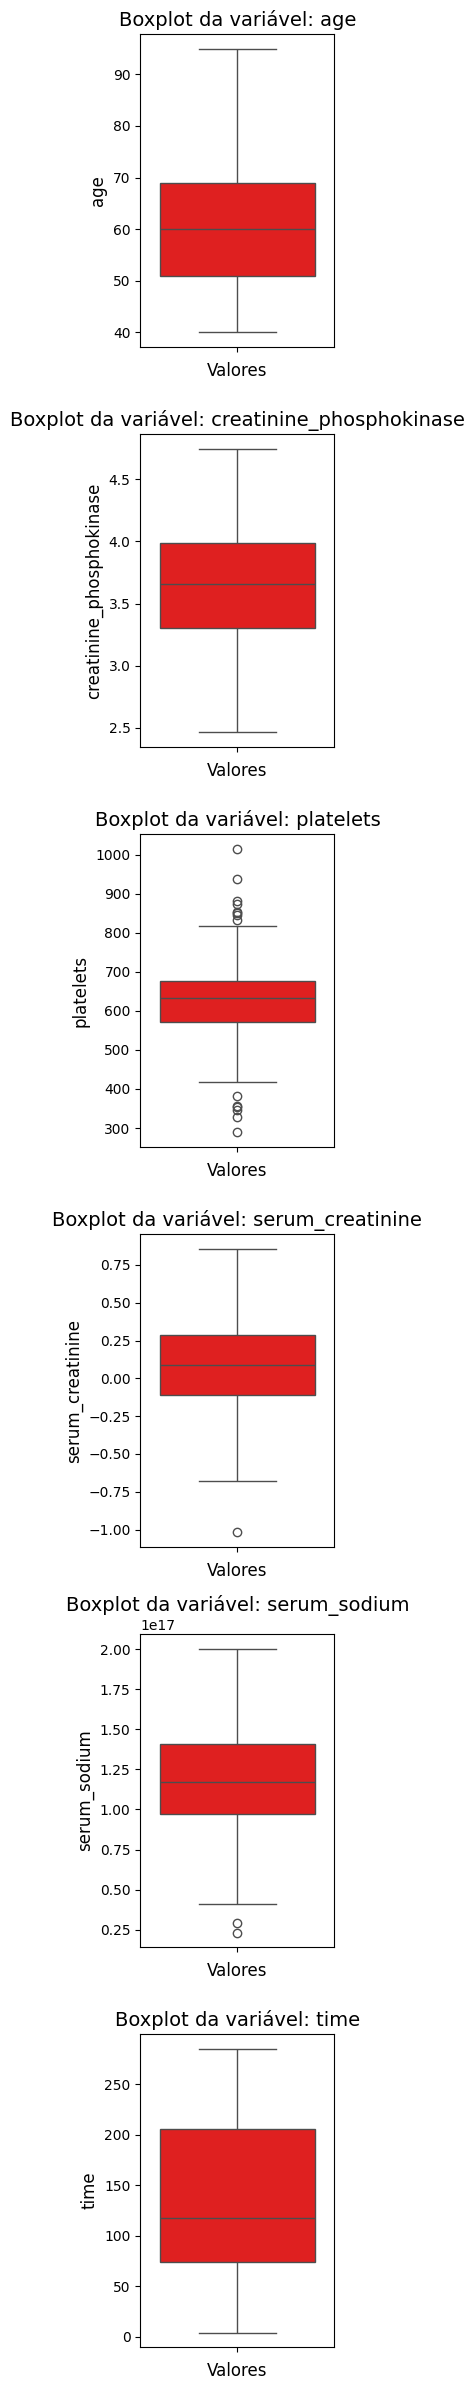

In [705]:
# Configuração dos subplots
fig, axes = plt.subplots(nrows=len(var_simetria), ncols=1, figsize=(3, 4 * len(var_simetria)))

# Loop para criar um boxplot para cada variável no eixo Y
for i, var in enumerate(var_simetria):
    sns.boxplot(data=X_train, y=var, ax=axes[i], color="red")
    axes[i].set_title(f"Boxplot da variável: {var}", fontsize=14)
    axes[i].set_ylabel(var, fontsize=12)
    axes[i].set_xlabel("Valores", fontsize=12)

# Ajuste para evitar sobreposição
plt.tight_layout()
plt.show()


##### 2.5 **`ejection_fraction`**

In [706]:
# Definindo o discretizador
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Selecionando a variável de interesse para discretização
ejection_fraction_train = X_train[['ejection_fraction']]

# Aplicando o discretizador no X_train
X_train['ejection_fraction'] = discretizer.fit_transform(ejection_fraction_train)

# Aplicando o discretizador no X_test com a mesma transformação
ejection_fraction_test = X_test[['ejection_fraction']]
X_test['ejection_fraction'] = discretizer.transform(ejection_fraction_test)


##### 2.6 Variáveis Flag's

In [707]:
flags = ['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT','ejection_fraction']

In [708]:
# Combine os dados de treino
train_data_pt = pd.concat([X_train, y_train], axis=1)

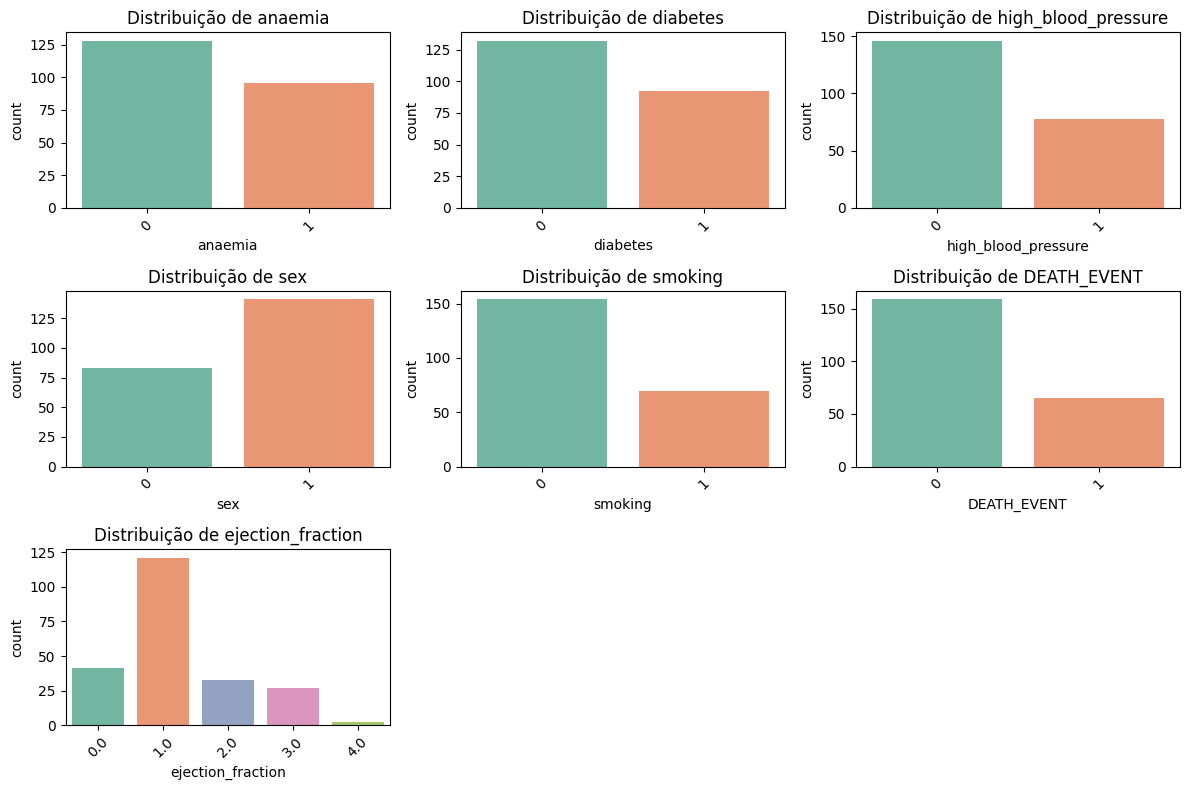

In [709]:
# Configurando o gráfico
plt.figure(figsize=(12, 8))

# Plotando cada variável categórica
for i, flag in enumerate(flags, 1):
    plt.subplot(3, 3, i)  # ajustando a grade de subgráficos
    sns.countplot(x=flag, data=train_data_pt, palette='Set2')
    plt.title(f'Distribuição de {flag}')
    plt.xticks(rotation=45)

plt.tight_layout()  # ajusta o layout para não sobrepor os gráficos
plt.show()


In [710]:
# Filtrando o DataFrame para DEATH_EVENT = 1
death_event_1 = train_data[train_data['DEATH_EVENT'] == 1]

# Contando o número de linhas
num_linhas = death_event_1.shape[0]

print(f'O número de linhas onde DEATH_EVENT = 1 é: {num_linhas}')

O número de linhas onde DEATH_EVENT = 1 é: 65


##### 2.6 Correlação de Pearson após Transformações

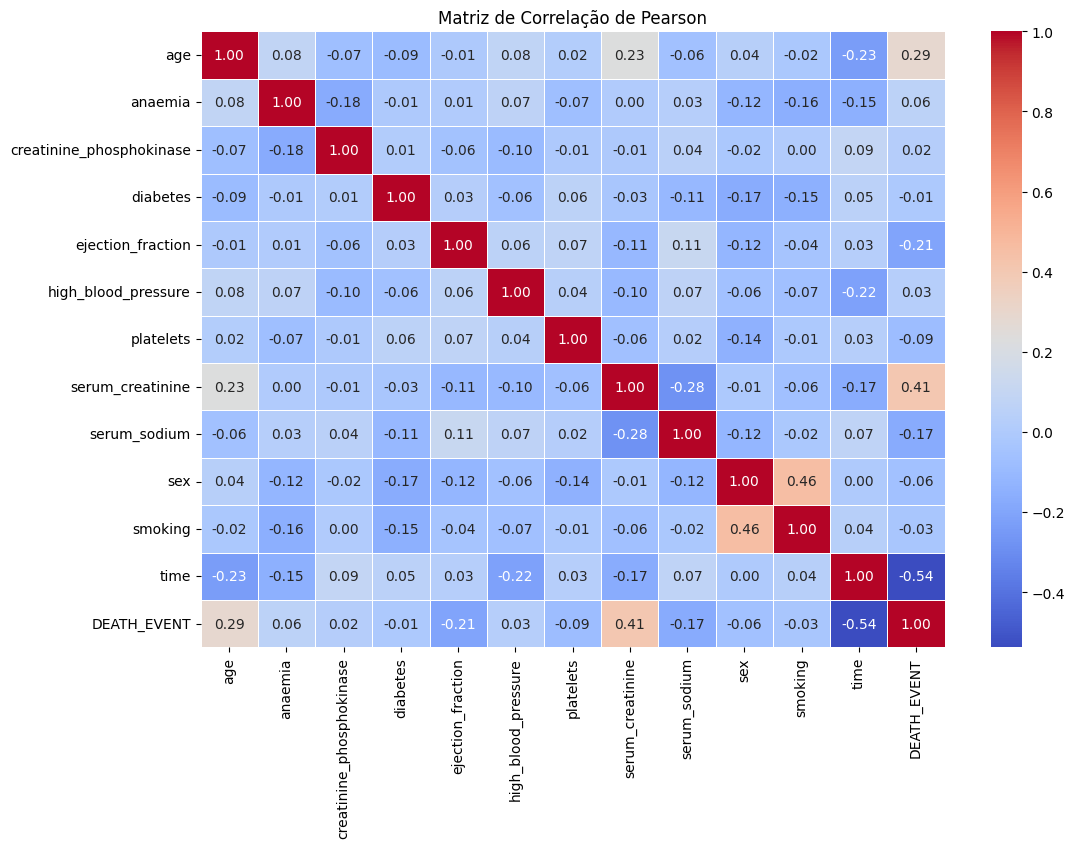

In [711]:
# Calcular a correlação de Spearman
cp = train_data_pt.corr(method='pearson')

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(cp, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação de Pearson')
plt.show()

#### 3. Feature Enginnering

###### Nessa etapa vamos explorar a utilização da biblioteca Feature-Engine para a criação de features automáticas com o objetivo de otimizar ainda mais as variáveis no dataset

###### A Feature-engine é uma biblioteca Python projetada para facilitar o processo de engenharia de features em datasets tabulares, com foco em pré-processamento, transformação e criação de novas features. Ela fornece uma série de ferramentas para melhorar a qualidade e a performance do modelo de machine learning por meio da manipulação das variáveis.

In [712]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 225 to 102
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       224 non-null    float64
 1   anaemia                   224 non-null    int64  
 2   creatinine_phosphokinase  224 non-null    float64
 3   diabetes                  224 non-null    int64  
 4   ejection_fraction         224 non-null    float64
 5   high_blood_pressure       224 non-null    int64  
 6   platelets                 224 non-null    float64
 7   serum_creatinine          224 non-null    float64
 8   serum_sodium              224 non-null    float64
 9   sex                       224 non-null    int64  
 10  smoking                   224 non-null    int64  
 11  time                      224 non-null    int64  
dtypes: float64(6), int64(6)
memory usage: 22.8 KB


In [713]:
renal = ['serum_creatinine','creatinine_phosphokinase']
metabolica = ['platelets','creatinine_phosphokinase']
deseq = ['serum_sodium','serum_creatinine']
risk = ['high_blood_pressure','diabetes']
time_renal = ['time','serum_creatinine']
cardio_resistance = ['age', 'serum_sodium']
creatinine_time_effect = ['time', 'creatinine_phosphokinase']
metabolic_pressure = ['high_blood_pressure', 'platelets']
combined_risk = ['high_blood_pressure', 'diabetes', 'anaemia']

#Combinação com Somas
math_sum = MathFeatures(variables=renal, func='sum')
X_train = math_sum.fit_transform(X_train)
X_test = math_sum.fit_transform(X_test)

math_sum = MathFeatures(variables=deseq, func='sum')
X_train = math_sum.fit_transform(X_train)
X_test = math_sum.fit_transform(X_test)

math_sum = MathFeatures(variables=cardio_resistance, func='sum')
X_train = math_sum.fit_transform(X_train)
X_test = math_sum.transform(X_test)

math_sum = MathFeatures(variables=combined_risk, func='sum')
X_train = math_sum.fit_transform(X_train)
X_test = math_sum.transform(X_test)

#Combinação com produtos
math_prod = MathFeatures(variables=metabolica, func='prod')
X_train = math_prod.fit_transform(X_train)
X_test = math_prod.fit_transform(X_test)

math_prod = MathFeatures(variables=time_renal, func='prod')
X_train = math_prod.fit_transform(X_train)
X_test = math_prod.fit_transform(X_test)

math_prod = MathFeatures(variables=risk, func='prod')
X_train = math_prod.fit_transform(X_train)
X_test = math_prod.fit_transform(X_test)

math_prod = MathFeatures(variables=creatinine_time_effect, func='prod')
X_train = math_prod.fit_transform(X_train)
X_test = math_prod.transform(X_test)

math_prod = MathFeatures(variables=metabolic_pressure, func='prod')
X_train = math_prod.fit_transform(X_train)
X_test = math_prod.transform(X_test)

In [714]:
# Combine os dados de treino
train_data_fe = pd.concat([X_train, y_train], axis=1)

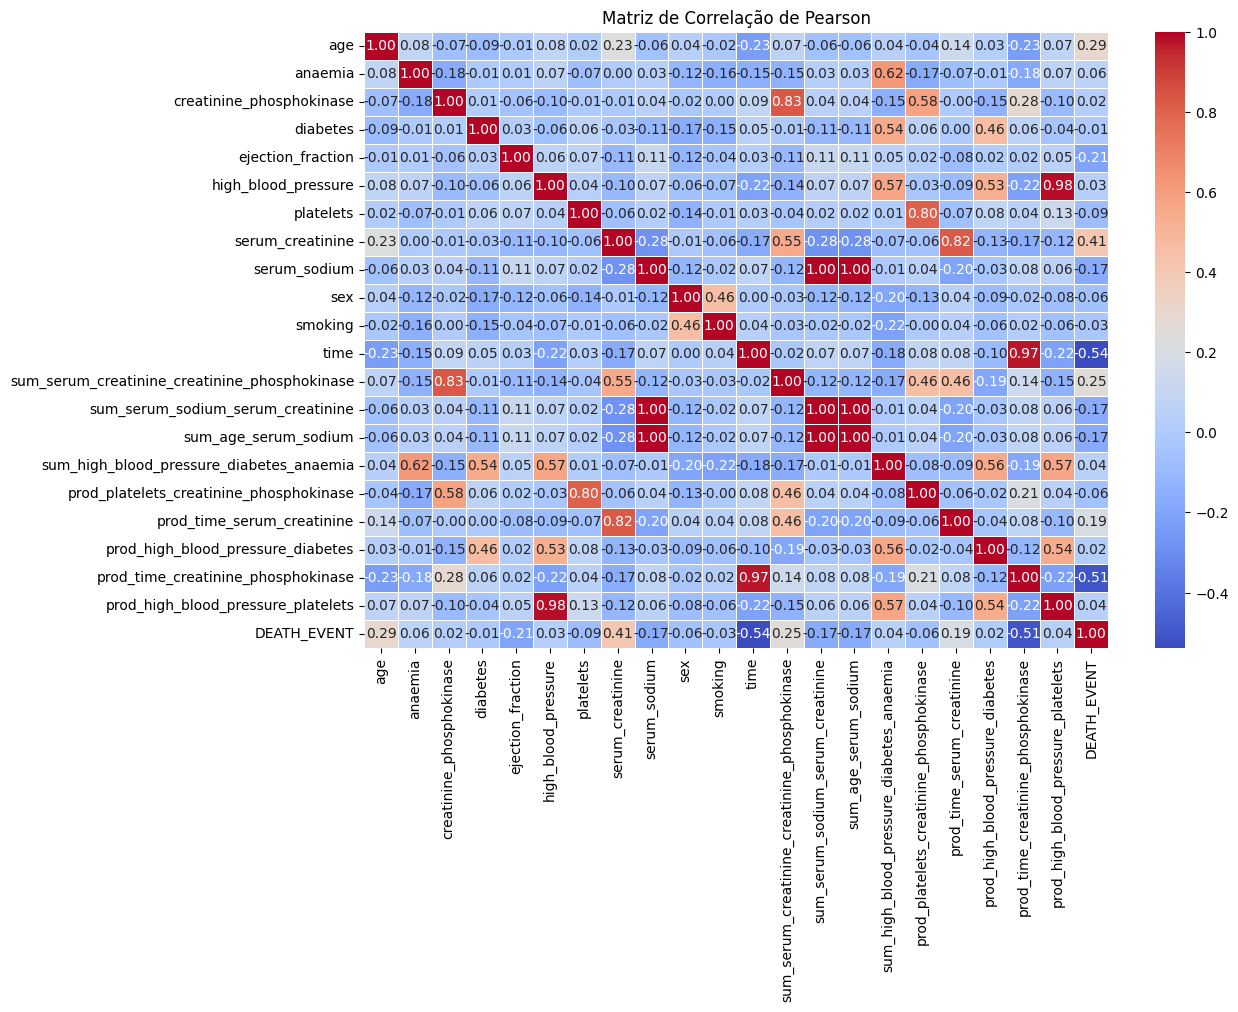

In [715]:
# Calcular a correlação de Spearman
cp_autofeatures = train_data_fe.corr(method='pearson')

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(cp_autofeatures, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação de Pearson')
plt.show()

##### 4. Treinamento do Modelo

##### 4.1 Reamostragem utilizando SMOTE

###### SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de reamostragem usada para lidar com o desbalanceamento de classes em conjuntos de dados. Ela gera novas amostras sintéticas da classe minoritária, criando exemplos semelhantes às instâncias existentes, ao invés de simplesmente duplicá-las. Isso ajuda a melhorar a performance de modelos de aprendizado de máquina, especialmente quando há um desequilíbrio significativo entre as classes.

In [723]:
# Inicializando o SMOTE
smote = SMOTE(random_state=42)

# Aplicando o SMOTE para balancear as classes no conjunto de treino
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Verificando o número de amostras após o SMOTE
print(f'Número de amostras após SMOTE: {len(y_train_over)}')

# Contando o número de exemplos de cada classe após o SMOTE
class_counts = y_train_over.value_counts()

print(f'Contagem de classes após o SMOTE:\n{class_counts}')


Número de amostras após SMOTE: 318
Contagem de classes após o SMOTE:
DEATH_EVENT
0    159
1    159
Name: count, dtype: int64


##### 4.2 **Treinando diversos Modelos de Classificação**

               Model  Accuracy  Precision    Recall  F1-Score
0      Random Forest  0.733333   0.703704  0.612903  0.655172
1  Gradient Boosting  0.720000   0.678571  0.612903  0.644068
2            XGBoost  0.760000   0.724138  0.677419  0.700000


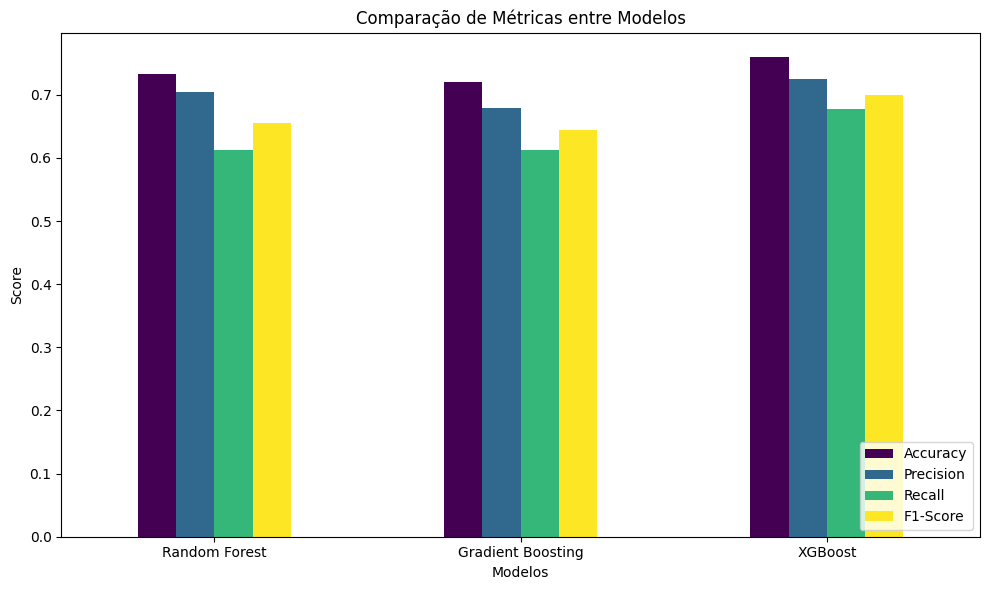

In [724]:
# Definir os modelos para avaliação
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
}

# DataFrame para armazenar os resultados das métricas
metrics_table = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Iterar sobre os modelos
for model_name, model in models.items():
    # Treinar o modelo
    model.fit(X_train_over, y_train_over)
    
    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Calcular as métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Adicionar os resultados ao DataFrame usando pd.concat()
    metrics_table = pd.concat([metrics_table, pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
    })], ignore_index=True)

# Exibir a tabela de métricas
print(metrics_table)

# Opcional: Exibir a tabela como gráfico de barras empilhadas
metrics_table.set_index('Model').plot(kind='bar', figsize=(10, 6), rot=0, colormap='viridis')
plt.title('Comparação de Métricas entre Modelos')
plt.ylabel('Score')
plt.xlabel('Modelos')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


##### 4.3 **XGBoost**

In [725]:
# Treinar o modelo XGBoost
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train_over, y_train_over)

# Salvar o modelo treinado
joblib.dump(xgboost_model, 'xgboost_baseline.joblib')

['xgboost_baseline.joblib']

##### 4.4 Matriz de Confusão

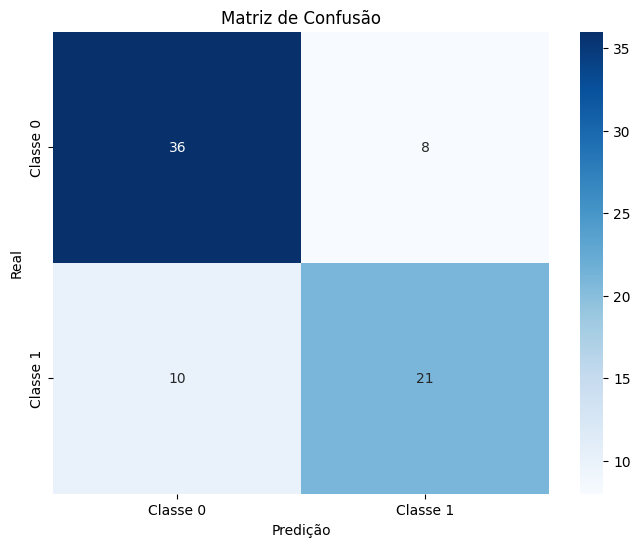

In [726]:
# Fazer previsões no conjunto de teste
y_pred = xgboost_model.predict(X_test)

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão com seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()


##### 4.4 Otimização de Hiperparâmetros

In [727]:
# Definir o espaço de hiperparâmetros a ser pesquisado
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 11, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': np.arange(1, 9, 1)
}

# Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_dist,
    n_iter=75,  # Número de combinações aleatórias a serem testadas
    scoring='recall',  # Métrica para avaliação
    cv=4,  # Cross-validation com 4 folds
    verbose=2,  # Exibir progresso
    random_state=42,
    n_jobs=-1  # Usar todos os núcleos disponíveis
)

# Treinar o modelo com a busca de hiperparâmetros
random_search.fit(X_train_over, y_train_over)

# Exibir os melhores parâmetros encontrados
print(f"Melhores parâmetros: {random_search.best_params_}")

# Melhor modelo
xgboost_otimizado = random_search.best_estimator_

# Salvar o modelo otimizado
joblib.dump(xgboost_otimizado, 'xgboost_optimized_model.joblib')


Fitting 4 folds for each of 75 candidates, totalling 300 fits
Melhores parâmetros: {'subsample': 0.7, 'n_estimators': np.int64(150), 'min_child_weight': np.int64(4), 'max_depth': np.int64(5), 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7}


['xgboost_optimized_model.joblib']

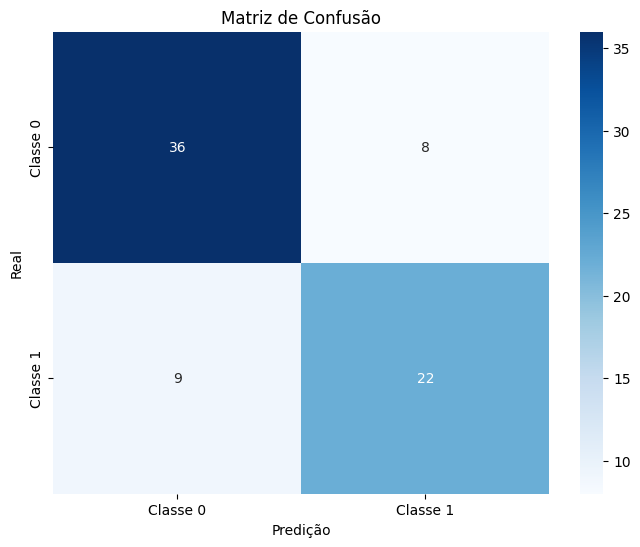

In [728]:
# Fazer previsões no conjunto de teste
y_pred = xgboost_otimizado.predict(X_test)

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão com seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()


In [729]:
# Gerar o classification report
report = classification_report(y_test, y_pred)

# Exibir o classification report
print(report)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        44
           1       0.73      0.71      0.72        31

    accuracy                           0.77        75
   macro avg       0.77      0.76      0.77        75
weighted avg       0.77      0.77      0.77        75



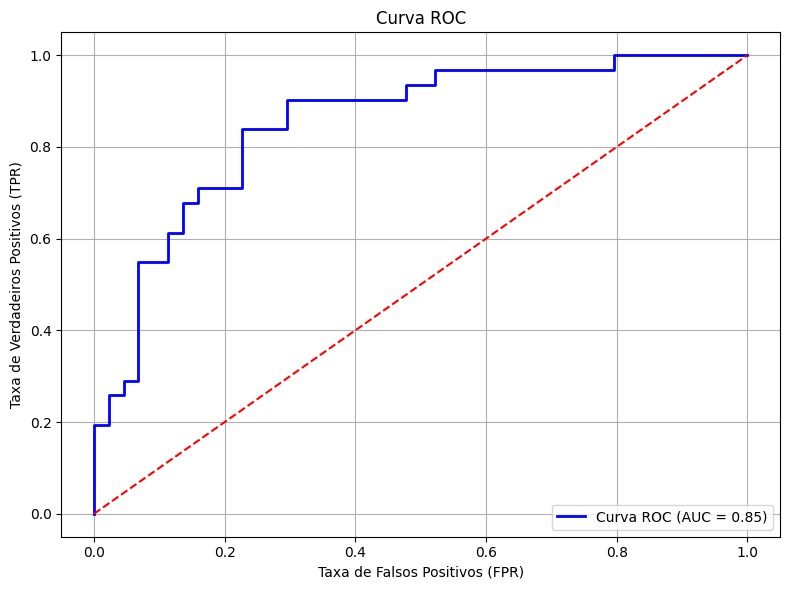

In [730]:
# Obter as probabilidades preditivas para a classe positiva
y_probs = xgboost_otimizado.predict_proba(X_test)[:, 1]

# Calcular a curva ROC com mais pontos para suavizar a curva
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular a AUC (Área sob a Curva)
auc = roc_auc_score(y_test, y_probs)

# Plotar a curva ROC com uma linha suave
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha diagonal
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Exibir o gráfico
plt.show()


O modelo escolhido foi o XGBoost otimizando parâmetros com o Randomized Search, onde os resultados finais apresentaram uma precisão de 0.73 e Recall de 0.71 para a classe 1 (Insuficiência Cardíaca).